In [1]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms

n_classes = 10
batch_size = 100

train_set, test_set = [
    datasets.MNIST(
        './',
        train=train_flag,
        download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: torch.flatten(x))
        ]),
    ) 
    for train_flag in [True, False]
]

train = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test = torch.utils.data.DataLoader(test_set, batch_size=test_set.__len__(), shuffle=True)

train_example_data, train_example_targets = next(iter(train))
test_example_data, test_example_targets = next(iter(test))

print(f"train batch size: {len(train)} x {train_example_data.shape}")
print(f"test batch size: {len(test)} x {test_example_data.shape}")

train batch size: 600 x torch.Size([100, 784])
test batch size: 1 x torch.Size([10000, 784])


# Excercise 1

In [2]:
import numpy as np
import torch.nn as nn
import torch.optim as optim

class Linear_Model(nn.Module):
    def __init__(self):
        super(Linear_Model, self).__init__()
        self.linear = nn.Linear(784, 10)
        self.linear.bias.data.fill_(0)
        
    def forward(self, x):
        h = self.linear(x)
        return F.softmax(h, dim=1) 

In [3]:
learning_rate = 0.5
model = Linear_Model()    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [4]:

iterations = 10000
epochs = iterations // len(train)
test_data, test_targets = next(iter(test))

train_acc = []
test_acc = []

def accuracy(pred, target):
    winners = pred.argmax(dim=1)
    corrects = (winners == target)
    return corrects.sum().float() / float(target.size(0) )

for epoch in range(epochs):
    for idx, (data, target) in enumerate(train):
        optimizer.zero_grad()

        output = model(data)

        loss = criterion(output, target)
        # get gradients w.r.t to parameters
        loss.backward()

        # update parameters
        optimizer.step()

        if idx % 100 == 0:
            train_accuracy = accuracy(output, target)
            train_acc.append(train_accuracy.item())
            
            val_output = model(test_data)
            test_accuracy = accuracy(val_output, test_targets)
            test_acc.append(test_accuracy.item())
        
        
    print('epoch {}, loss {}'.format(epoch, loss.item()))



epoch 0, loss 1.6058433055877686
epoch 1, loss 1.583632230758667
epoch 2, loss 1.560001015663147
epoch 3, loss 1.5885703563690186
epoch 4, loss 1.517427682876587
epoch 5, loss 1.534970760345459
epoch 6, loss 1.5581958293914795
epoch 7, loss 1.548012375831604
epoch 8, loss 1.529762625694275
epoch 9, loss 1.5729281902313232
epoch 10, loss 1.5379917621612549
epoch 11, loss 1.5520325899124146
epoch 12, loss 1.60878586769104
epoch 13, loss 1.552700400352478
epoch 14, loss 1.5559751987457275
epoch 15, loss 1.5225961208343506


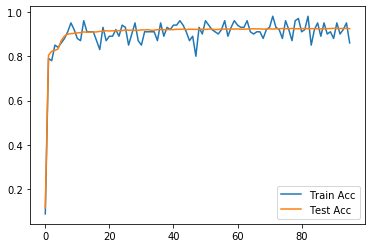

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline

epochs = range(len(train_acc))
plt.plot(epochs, train_acc, label="Train Acc")
plt.plot(epochs, test_acc, label="Test Acc")
plt.legend()

# Excercise 2

In [26]:
# function replicated from: https://discuss.pytorch.org/t/implementing-truncated-normal-initializer/4778/20
# not working quite ... need improvement
def truncated_normal_(tensor, mean=0, std=1):
    size = tensor.shape
    tmp = tensor.new_empty(size + (4,)).normal_()
    valid = (tmp < 2) & (tmp > -2)
    ind = valid.max(-1, keepdim=True)[1]
    tensor.data.copy_(tmp.gather(-1, ind).squeeze(-1))
    tensor.data.mul_(std).add_(mean)
    return tensor

def weights_init(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        m.bias.data.fill_(0.1)
        truncated_normal_(m.weight, 0, 0.01)
        
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(784, 1500)
        self.linear2 = nn.Linear(1500, 1500)
        self.linear3 = nn.Linear(1500, 1500)
        self.linear4 = nn.Linear(1500, 10)
        self.apply(weights_init)
        
    def forward(self, x):
        relu = nn.ReLU()
        h1 = relu(self.linear1(x))
        h2 = relu(self.linear2(h1))
        h3 = relu(self.linear3(h2))
        # the function softmax is not included as nn.CrossEntropyLoss applies a softmax (source: https://discuss.pytorch.org/t/pytorch-equivalence-to-sparse-softmax-cross-entropy-with-logits-in-tensorflow/18727/2)
        return self.linear4(h3) 
    

In [28]:
learning_rate, betas, eps = 0.001, [0.9, 0.999], 1e-8

model = MLP()    
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=betas)

In [29]:
iterations = 20000
epochs = iterations // len(train)
test_data, test_targets = next(iter(test))

train_acc = []
test_acc = []

def accuracy(pred, target):
    winners = pred.argmax(dim=1)
    corrects = (winners == target)
    return corrects.sum().float() / float(target.size(0) )

for epoch in range(epochs):
    for idx, (data, target) in enumerate(train):
        optimizer.zero_grad()

        output = model(data)

        loss = criterion(output, target)
        # get gradients w.r.t to parameters
        loss.backward()

        # update parameters
        optimizer.step()

        if idx % 100 == 0:
            train_accuracy = accuracy(output, target)
            train_acc.append(train_accuracy.item())
            
            val_output = model(test_data)
            test_accuracy = accuracy(val_output, test_targets)
            test_acc.append(test_accuracy.item())
        
        
    print('epoch {}, loss {}'.format(epoch, loss.item()))

epoch 0, loss 0.11816820502281189
epoch 1, loss 0.08549151569604874
epoch 2, loss 0.05404572933912277
epoch 3, loss 0.0293661430478096
epoch 4, loss 0.09473295509815216
epoch 5, loss 0.013790199533104897
epoch 6, loss 0.013209978118538857
epoch 7, loss 0.056404534727334976
epoch 8, loss 0.0439533032476902
epoch 9, loss 0.015315396711230278
epoch 10, loss 0.022290358319878578
epoch 11, loss 0.033046528697013855
epoch 12, loss 0.004483635537326336
epoch 13, loss 0.005156689789146185
epoch 14, loss 0.0025474654976278543
epoch 15, loss 0.0012081601889804006
epoch 16, loss 0.00028488587122410536
epoch 17, loss 0.0014893546467646956
epoch 18, loss 0.00010053966252598912
epoch 19, loss 0.001051666447892785
epoch 20, loss 1.745878762449138e-05
epoch 21, loss 0.004360769409686327
epoch 22, loss 0.0029462939128279686
epoch 23, loss 0.01227305456995964
epoch 24, loss 0.0003540171019267291
epoch 25, loss 0.005697505082935095
epoch 26, loss 0.00017307113739661872
epoch 27, loss 4.617231388692744e-0

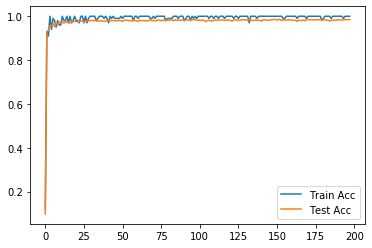

In [30]:
epochs = range(len(train_acc))
plt.plot(epochs, train_acc, label="Train Acc")
plt.plot(epochs, test_acc, label="Test Acc")
plt.legend()

# Excercise 3

In [31]:
class MLP_w_DOUT(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(784, 1500),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1500, 1500),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1500, 1500),
            nn.ReLU(),
            nn.Dropout(),
            # the function softmax is not included as nn.CrossEntropyLoss applies a softmax (source: https://discuss.pytorch.org/t/pytorch-equivalence-to-sparse-softmax-cross-entropy-with-logits-in-tensorflow/18727/2)
            nn.Linear(1500, 10)
        )
        self.apply(weights_init)
        
    def forward(self, x):
        return self.network(x) 